In [1]:
import anndata
import umap
import xgboost
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import re
import joblib
import plotly
regex = re.compile(r"perturbation_experiment_([^_]+)_level")

# base definition and original adata:
if not "adata" in locals():
    levels = ["0", "0.5", "1.0"]
    data_dir = "/data/gene_perturbation_colon_epithelial_scGPT_with_binning_1"
    file_pattern = data_dir + "/perturbation_experiment_{gene}_level_{level}"
    base_fname = file_pattern.format(gene = "JUND", level = "1.0")
    base_embeddings = np.load(f"{base_fname}.embeddings.npy")
    adata = anndata.read_h5ad(f"{base_fname}.h5ad")
    base_df = adata.obs[["tissue", "cell_type", 'sex', 'development_stage',"disease"]].copy()
data_dir = "/data/colon_epithelial_cellxgene_perturbation_4"
file_pattern = data_dir + "/perturbations/perturbation_experiment_{gene}_level_{level}"
genes = set([regex.search(f.name).group(1) for f in list(Path(data_dir+"/perturbations").glob("*.npz"))])
model_filename = "cgboost_on_emebeddings_with_binning_predict_disease_2024-05-05.pkl"
base_df.sample(5, random_state=0)

,tissue,cell_type,sex,development_stage,disease
cell_id,,,,,
N128624_E-GTAGATCAGCTGTTCA,colonic epithelium,enterocyte,female,fifth decade human stage,Crohn disease
N21_Epi_A-CTGAATCTAAGGCG,left colon,enterocyte,female,human adult stage,normal
N124246_L-AACAACCAGTATTAGG,lamina propria of mucosa of colon,brush cell,male,fourth decade human stage,Crohn disease
N175041_N2-TTAGGACGTGGGTATG,left colon,enterocyte,male,seventh decade human stage,Crohn disease
N51_Epi_B-GCATGCGGTCTGCGGT,caecum,enterocyte,male,human adult stage,normal


In [2]:
colon_crohn_model = joblib.load("colon_crohn_model_xgboost.joblib")
colon_umap_df = pd.read_parquet("colon_umap.parquet")
colon_umap_by_disease_df = pd.read_parquet("colon_umap_by_disease.parquet")
colon_umap_by_cell_type_df = pd.read_parquet("colon_umap_by_cell_type_df.parquet")
perturbation_df = pd.read_parquet("perturbation_df_colon_5.parquet")
perturbation_df.shape

n_cases = perturbation_df.gene.nunique() * 2 
umaps = pd.concat([colon_umap_df] * n_cases)
perturbation_df[["umap_x", "umap_y"]] = pd.concat([colon_umap_df] * n_cases).values


In [3]:
import plotly.graph_objs as go
import plotly.express as px

level = "KO"

# Define a color map for cell types
cell_type_colors = px.colors.qualitative.Plotly  # Use Plotly's qualitative color set
unique_cell_types = perturbation_df["cell_type"].unique()
color_mapping = {cell_type: color for cell_type, color in zip(unique_cell_types, cell_type_colors)}

for gene in perturbation_df.gene.unique()[0:1]:
    # Filter the data for the current gene and level
    df = perturbation_df.query(f"gene == '{gene}'").query(f"level == '{level}'").copy()
    df["umap_x"] = colon_umap_by_cell_type_df["umap_x"].values
    df["umap_y"] = colon_umap_by_cell_type_df["umap_y"].values
    df["cell_type"] = colon_umap_by_cell_type_df["cell_type"].values

    # Map each cell type to its corresponding color
    df["cell_type_color"] = df["cell_type"].map(color_mapping)
    df["disease_color"] = df["disease"].map({'normal': "blue", "Crohn disease": "yellow"})

    fig = go.Figure()

    # Add the background scatter plot colored by `cell_type`
    fig.add_trace(
        go.Scatter(
            x=df["umap_x"],
            y=df["umap_y"],
            mode="markers",
            marker=dict(size=3, color=df["disease_color"], opacity=0.2),  # Set marker size to 1 pixel
            name="Background",
            text=df["disease"],  # Display cell type on hover
        )
    )

    # Filter the data for significant perturbation changes
    filtered = df.query("abs(proba_disease_after_pertrubation) > 0.2")

    # Create the second scatter plot with the red-to-green colormap
    fig2 = px.scatter(
        filtered,
        x="umap_x",
        y="umap_y",
        color="proba_disease_after_pertrubation",
        color_continuous_scale="RdYlGn_r",  # Reversed red-to-green colormap
        range_color=(-1, 1),
        title=f"{gene} : {level}",
        opacity=0.9,
        render_mode='webgl',
    )

    # Add the filtered points to the initial background scatter plot
    for trace in fig2.data:
        trace.marker.update(size=4)  # Set marker size to 1 pixel
        fig.add_trace(trace)

    # Update the layout to include a color bar title and better legend positioning
    fig.update_layout(
        coloraxis_colorbar=dict(title="Disease Probability Change"),
        legend=dict(x=1.05, y=1),
        title=f"{gene} : {level}",
        width=1000,
        height=900,
    )

    # fig.show()


<Axes: xlabel='gene', ylabel='cell_id'>

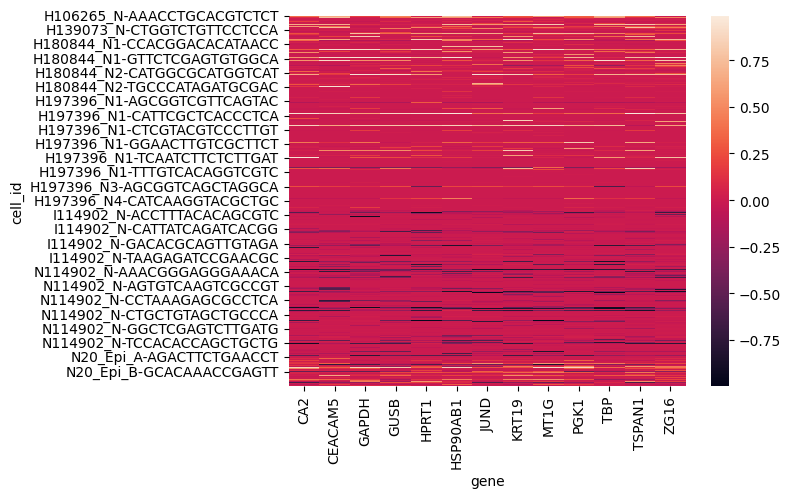

In [4]:
pv = perturbation_df.query("level == 'KO'")[["gene", "proba_disease_after_pertrubation"]].pivot(columns="gene", values="proba_disease_after_pertrubation")

sns.heatmap(pv)

In [5]:
crohn_related_genes = dict([
    ['CA2', 'No'],
    ['CEACAM5', 'Yes'],
    ['GAPDH', 'No'],
    ['GUSB', 'No'],
    ['HPRT1', 'No'],
    ['HSP90AB1', 'No'],
    ['JUND', 'Yes'],
    ['KRT19', 'No'],
    ['MT1G', 'No'],
    ['PGK1', 'No'],
    ['TBP', 'No'],
    ['TSPAN1', 'No'],
    ['ZG16', 'Yes']
])

<Axes: xlabel='gene', ylabel='disease-cell_type'>

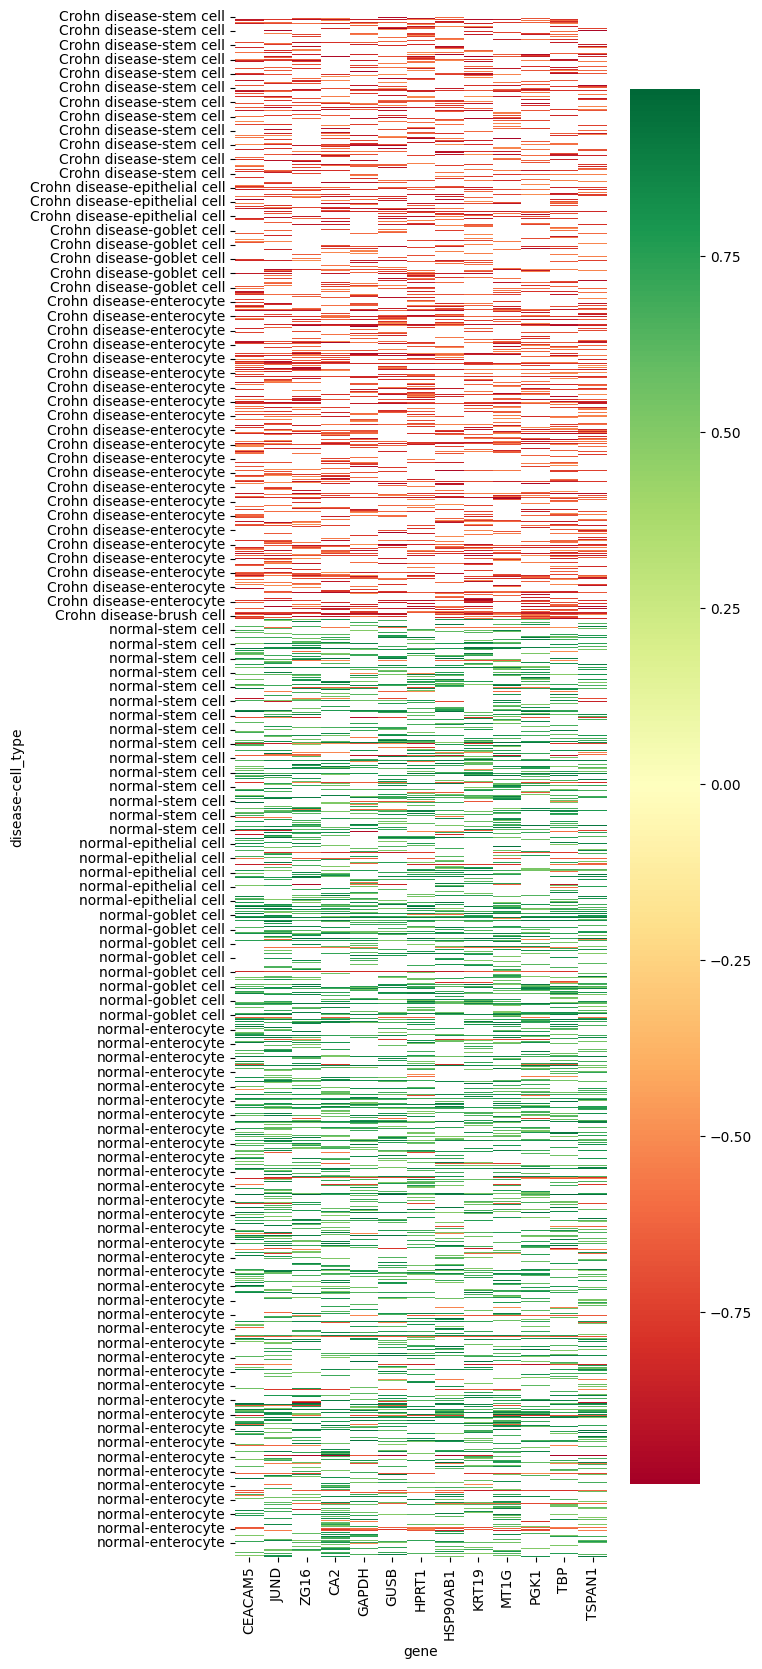

In [6]:
cutoff = 0.5
pv = perturbation_df.query("level == 'KO'")[["gene", "proba_disease_after_pertrubation"]].query("abs(proba_disease_after_pertrubation) > @cutoff").pivot(columns="gene", values="proba_disease_after_pertrubation")

pv = pv.T.assign(crohn_related = pv.T.index.map(crohn_related_genes)).sort_values('crohn_related', ascending=False).T[:-1]

df = base_df[["cell_type","disease"]].loc[pv.index]
pv.insert(0, "cell_type", df["cell_type"].values)
pv.insert(0, "disease", df["disease"].values)
pv = pv.sort_values(["disease", "cell_type"]).set_index(["disease", "cell_type"]).astype(float)
plt.figure(figsize=[6, 20])
sns.heatmap(pv, cmap="RdYlGn")


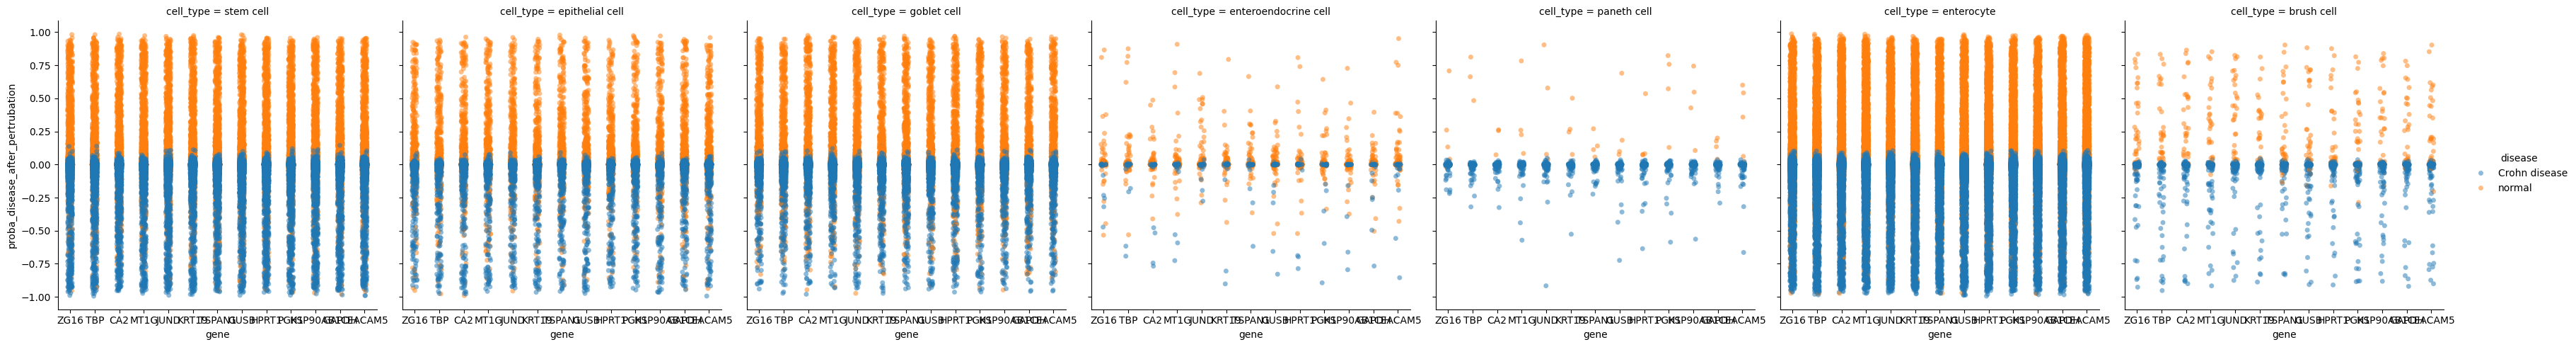

In [7]:
perturbation_df
# sns.lmplot(data = perturbation_df.query("level == 'KO'"), x="umap_x", y="umap_y", col="gene", row="cell_type", hue="proba_disease_after_pertrubation")

sns.catplot(data = perturbation_df.query("level == 'KO'"), x='gene', y="proba_disease_after_pertrubation", col="cell_type", hue="disease", alpha=0.5)

# Sensitivity analysis

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import pickle

np.random.seed(41)

data_dir = "/data/colon_epithelial_cellxgene_perturbation_4"
result_dir = "/scratch"
x_index = base_df.reset_index().query("cell_id == @perturbation_df.index.tolist()").index.tolist()
x = base_embeddings[x_index]
y = pd.Categorical(base_df.iloc[x_index]["disease"]).codes

def check_model(gene=None, level=None, x=None, y=y):


    out_fname = f"{result_dir}/cross_val_results_for_perturbation_{gene}_{level}.pickle"

    if gene is None:
        out_fname = f"{result_dir}/cross_val_results_for_perturbation_base.pickle"
    else:
        filename = f"{data_dir}/perturbations/perturbation_experiment_{gene}_level_{level}.embeddings.npz"
    if Path(out_fname).exists():
        try:
            with open(out_fname, "rb") as f:
                return pickle.load(f)
        except:
            pass
    
    if x is None:
        x = np.load(filename)["emb"][x_index]

    
    
    model = XGBClassifier()
    print("Cross-validation")
    results = cross_val_score(model, x, y, n_jobs=6, verbose=1, cv=5)
    with open(out_fname, "wb") as f:
        pickle.dump(results, f)
    return results

check_model("CEACAM5", 5.0)

array([0.97838617, 0.88994957, 0.88706772, 0.86236714, 0.68474149])

In [30]:
if not "results" in globals():
    genes_bar = tqdm(genes)
    control = check_model(x=x)
    results = [{"gene" : "control", "level":"control", "mean" : control.mean(), "std" : control.std(),"accuracy" : control}]
    for gene in genes_bar:
        for level in [0, 5.0]:
            genes_bar.set_description(f"{gene} : {level}")
            result = check_model(gene, level)
            results += [{"gene": gene, "level": level, "mean": result.mean(), "std": result.std(), "accuracy" : result}]
pd.DataFrame(results)

,gene,level,mean,std,accuracy
0,control,control,0.863276,0.100673,"[0.9778458213256485, 0.9048991354466859, 0.880..."
1,CA2,0,0.859205,0.098112,"[0.9780259365994236, 0.8939121037463977, 0.883..."
2,CA2,5.0,0.865258,0.099132,"[0.979106628242075, 0.9061599423631124, 0.8908..."
3,TSPAN1,0,0.862412,0.098164,"[0.9751440922190202, 0.8971541786743515, 0.887..."
4,TSPAN1,5.0,0.865618,0.095201,"[0.9780259365994236, 0.9018371757925072, 0.885..."
5,HPRT1,0,0.864105,0.096426,"[0.9780259365994236, 0.8962536023054755, 0.884..."
6,HPRT1,5.0,0.859926,0.099151,"[0.974963976945245, 0.8967939481268011, 0.8856..."
7,GUSB,0,0.863637,0.096939,"[0.9771253602305475, 0.9034582132564841, 0.881..."
8,GUSB,5.0,0.864862,0.094114,"[0.9719020172910663, 0.8969740634005764, 0.889..."
9,TBP,0,0.864105,0.096998,"[0.9762247838616714, 0.896613832853026, 0.8881..."


(0.8, 1.0)

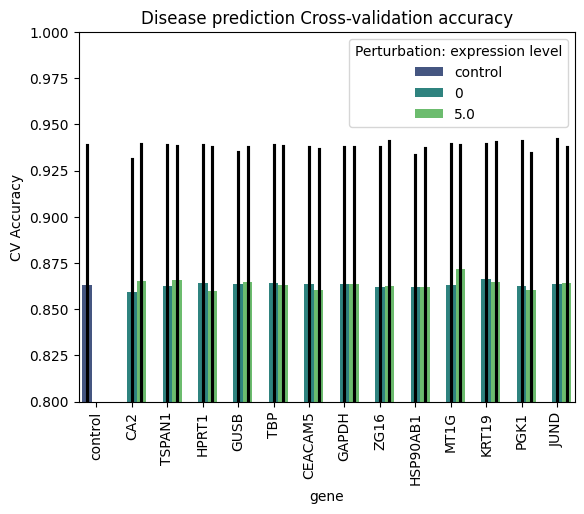

In [36]:
res = pd.DataFrame(results).explode("accuracy")
# plt.figure(figsize=(10, 6))
sns.barplot(data=res, x="gene", y="accuracy", hue="level", palette="viridis", err_kws={'color': 'black'})

plt.ylabel("CV Accuracy")
plt.title("Disease prediction Cross-validation accuracy")
plt.legend(title="Perturbation: expression level")
plt.xticks(rotation=90)

# limit the x values to start from 0.8:
plt.ylim(0.8, 1)
